In [1]:
import os
import pandas as pd
import geopandas as gpd

In [2]:
column_name_mapper = {
  'obs_value': 'value',
  'c_age_name': 'age',
  'age_name': 'age',
  'gender_name': 'gender'
}
age_value_mapper = {
  'All categories: Age 16+': 'Aged 16+',
  'Aged 16 to 24': 'Aged 16-24'
}

In [3]:
claimant_columns = ['GEOGRAPHY_CODE', 'GEOGRAPHY_NAME', 'GENDER_NAME', 'AGE_NAME', 'MEASURE_NAME', 'OBS_VALUE']
claimants = pd.read_csv('../../data/raw/claimants-by-pcon-2010-latest.csv', usecols=claimant_columns)
claimants.columns = claimants.columns.str.lower()
claimants = claimants.rename(columns=column_name_mapper)
claimants = claimants.replace({ 'age': age_value_mapper })
claimants

,geography_name,geography_code,gender,age,measure_name,value
0,Berwick-upon-Tweed,E14000554,Total,Aged 16+,Claimant count,985
1,Berwick-upon-Tweed,E14000554,Total,Aged 16-24,Claimant count,170
2,Bishop Auckland,E14000569,Total,Aged 16+,Claimant count,1900
3,Bishop Auckland,E14000569,Total,Aged 16-24,Claimant count,430
4,Blaydon,E14000574,Total,Aged 16+,Claimant count,1675
...,...,...,...,...,...,...
1295,Strangford,N06000016,Total,Aged 16-24,Claimant count,335
1296,Upper Bann,N06000017,Total,Aged 16+,Claimant count,2430
1297,Upper Bann,N06000017,Total,Aged 16-24,Claimant count,410
1298,West Tyrone,N06000018,Total,Aged 16+,Claimant count,1695


This is population estimates for England and Wales only!

In [4]:
population_columns = ['GEOGRAPHY_CODE', 'GEOGRAPHY_NAME', 'GENDER_NAME', 'C_AGE_NAME', 'OBS_VALUE']
population = pd.read_csv('../../data/raw/population-estimates-by-pcon-2010-latest.csv', usecols=population_columns)
population.columns = population.columns.str.lower()
population['measure_name'] = 'Population estimate'
population = population.rename(columns=column_name_mapper)
population = population.replace({ 'age': age_value_mapper })
population

,geography_name,geography_code,gender,age,value,measure_name
0,Berwick-upon-Tweed,E14000554,Total,Aged 16+,65961,Population estimate
1,Berwick-upon-Tweed,E14000554,Total,Aged 16-24,5662,Population estimate
2,Bishop Auckland,E14000569,Total,Aged 16+,74720,Population estimate
3,Bishop Auckland,E14000569,Total,Aged 16-24,8250,Population estimate
4,Blaydon,E14000574,Total,Aged 16+,72751,Population estimate
...,...,...,...,...,...,...
1141,Vale of Glamorgan,W07000078,Total,Aged 16-24,10042,Population estimate
1142,Cardiff West,W07000079,Total,Aged 16+,75174,Population estimate
1143,Cardiff West,W07000079,Total,Aged 16-24,9430,Population estimate
1144,Cardiff South and Penarth,W07000080,Total,Aged 16+,95473,Population estimate


In [5]:
data = pd.concat([population, claimants]).pivot(index=['geography_code', 'geography_name', 'age', 'gender'], columns='measure_name', values='value')
data

measure_name                                                Claimant count  \
geography_code geography_name            age        gender                   
E14000530      Aldershot                 Aged 16+   Total           1870.0   
                                         Aged 16-24 Total            290.0   
E14000531      Aldridge-Brownhills       Aged 16+   Total           1295.0   
                                         Aged 16-24 Total            275.0   
E14000532      Altrincham and Sale West  Aged 16+   Total           1220.0   
...                                                                    ...   
W07000078      Vale of Glamorgan         Aged 16-24 Total            410.0   
W07000079      Cardiff West              Aged 16+   Total           2445.0   
                                         Aged 16-24 Total            490.0   
W07000080      Cardiff South and Penarth Aged 16+   Total           3430.0   
                                         Aged 16-24 Total            620.0   

measure_name                                                Population estimate  
geography_code geography_name            age        gender                       
E14000530      Aldershot                 Aged 16+   Total               84204.0  
                                         Aged 16-24 Total                9622.0  
E14000531      Aldridge-Brownhills       Aged 16+   Total               63864.0  
                                         Aged 16-24 Total                6827.0  
E14000532      Altrincham and Sale West  Aged 16+   Total               80428.0  
...                                                                         ...  
W07000078      Vale of Glamorgan         Aged 16-24 Total               10042.0  
W07000079      Cardiff West              Aged 16+   Total               75174.0  
                                         Aged 16-24 Total                9430.0  
W07000080      Cardiff South and Penarth Aged 16+   Total               95473.0  
                                         Aged 16-24 Total               12712.0  

[1300 rows x 2 columns]

In [6]:
data['Claimants percentage'] = data['Claimant count'] / data['Population estimate'] * 100
data[data['Claimants percentage'].notna()].reset_index().geography_code.str.slice(0, 1).unique()

array(['E', 'W'], dtype=object)

In [7]:
DATA_FILE = '../../data/processed/claimants/claimants-per-population-latest.csv'
os.makedirs(os.path.dirname(DATA_FILE), exist_ok=True)
data.to_csv(DATA_FILE)

In [8]:
map_data = (
  gpd.read_file('../../data/reference/pcon.geojson')
    .merge(
      data.reset_index().pivot(index='geography_code', columns='age', values='Claimants percentage'),
      left_on='PCON21CD',
      right_index=True,
      how='outer'
    )
)

In [9]:
map_data.columns

Index(['OBJECTID', 'PCON21CD', 'PCON21NM', 'BNG_E', 'BNG_N', 'LONG', 'LAT',
       'GlobalID', 'SHAPE_Length', 'SHAPE_Area', 'geometry', 'Aged 16+',
       'Aged 16-24'],
      dtype='object')

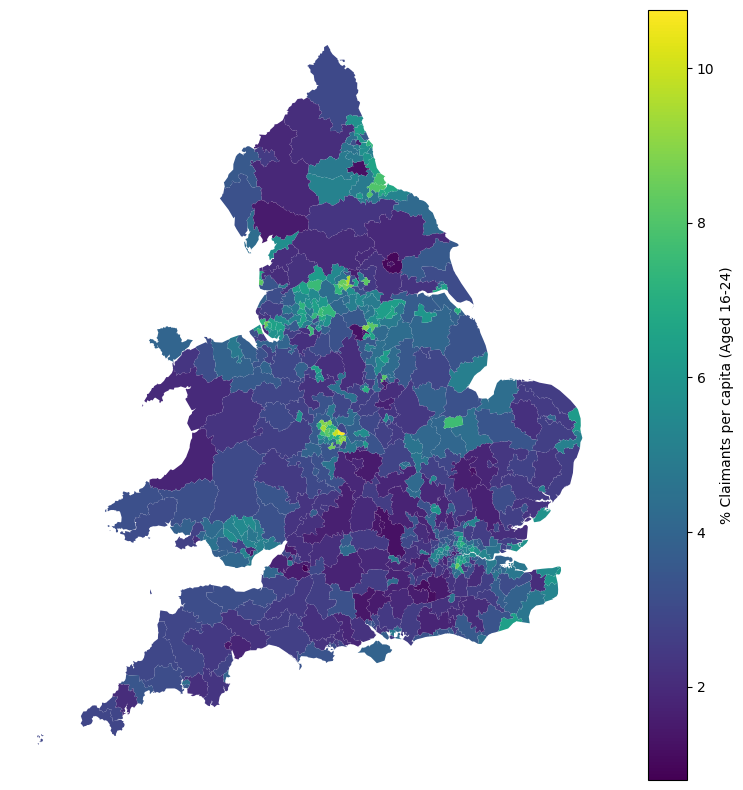

In [10]:
import matplotlib.pyplot as plt

map_data.plot(
    column='Aged 16-24',
    legend=True,
    legend_kwds={"label": "% Claimants per capita (Aged 16-24)", "orientation": "vertical"},
    figsize=(10,10)
).set_axis_off()

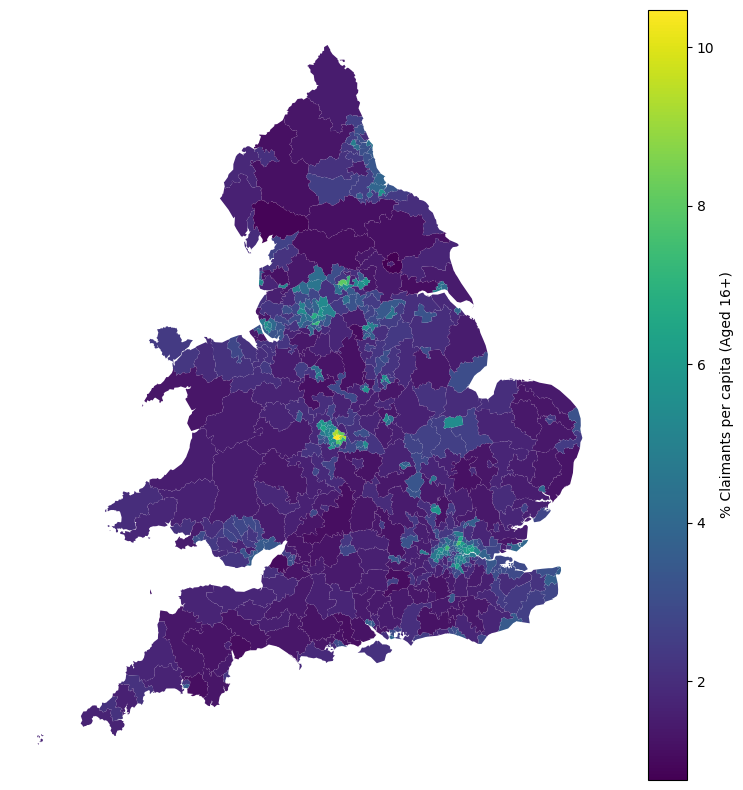

In [12]:
map_data.plot(
    column='Aged 16+',
    legend=True,
    legend_kwds={"label": "% Claimants per capita (Aged 16+)", "orientation": "vertical"},
    figsize=(10,10)
).set_axis_off()